## 실거래 데이터 기반 모델링

In [1]:
# 
import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 운영체제별 폰트 설정
if platform.system() == 'Darwin':  # macOS
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
    # 폰트 경로 설정 (예: 나눔고딕)
    font_path = 'C:/Windows/Fonts/NanumGothic.ttf'  # 실제 폰트 경로로 변경
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font_name)
else:  # Linux
    # 폰트 경로 설정 (예: 나눔고딕)
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 실제 폰트 경로로 변경
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font_name)

# 한글 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore') # 경고 문구 출력 X
import pandas as pd
import requests

In [2]:
# !pip install python-dotenv

In [31]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
from dotenv import load_dotenv
import os

load_dotenv()  # .env 파일 로딩

PUBLIC_SERVICE_KEY = os.getenv('PUBLIC_SERVICE_KEY')
url = 'https://apis.data.go.kr/1613000/RTMSDataSvcAptTrade/getRTMSDataSvcAptTrade'
params = {
    # 'LAWD_CD': '11680',   # 강남구
    # 'LAWD_CD': '41135',   # 분당구
    'LAWD_CD': '11500',   # 강서구
    'DEAL_YMD': '202503', # 2025년 3월
    'serviceKey': PUBLIC_SERVICE_KEY,
    # 'pageNo': '1',
    # 'numOfRows': '100'
}

response = requests.get(url, params=params)
root = ET.fromstring(response.content)

# rows = []
# for item in root.iter('item'):
#     row = {}
#     for child in item:
#         row[child.tag] = child.text
#     rows.append(row)

# df = pd.DataFrame(rows)
# print(df.head(5))
all_rows = []
page = 1
while True:
    params['pageNo'] = page
    response = requests.get(url, params=params)
    root = ET.fromstring(response.content)

    items = root.findall('.//item')
    if not items:
        break  # 더 이상 데이터 없음

    for item in items:
        row = {child.tag: child.text for child in item}
        all_rows.append(row)

    page += 1

df = pd.DataFrame(all_rows)
print(f"총 데이터 개수: {len(df)}")


총 데이터 개수: 461


In [32]:
df.columns

Index(['aptDong', 'aptNm', 'buildYear', 'buyerGbn', 'cdealDay', 'cdealType',
       'dealAmount', 'dealDay', 'dealMonth', 'dealYear', 'dealingGbn',
       'estateAgentSggNm', 'excluUseAr', 'floor', 'jibun', 'landLeaseholdGbn',
       'rgstDate', 'sggCd', 'slerGbn', 'umdNm'],
      dtype='object')

In [33]:
df.isnull().sum()

aptDong             0
aptNm               0
buildYear           0
buyerGbn            0
cdealDay            0
cdealType           0
dealAmount          0
dealDay             0
dealMonth           0
dealYear            0
dealingGbn          0
estateAgentSggNm    0
excluUseAr          0
floor               0
jibun               0
landLeaseholdGbn    0
rgstDate            0
sggCd               0
slerGbn             0
umdNm               0
dtype: int64

In [34]:
# !pip install missingno

<Axes: >

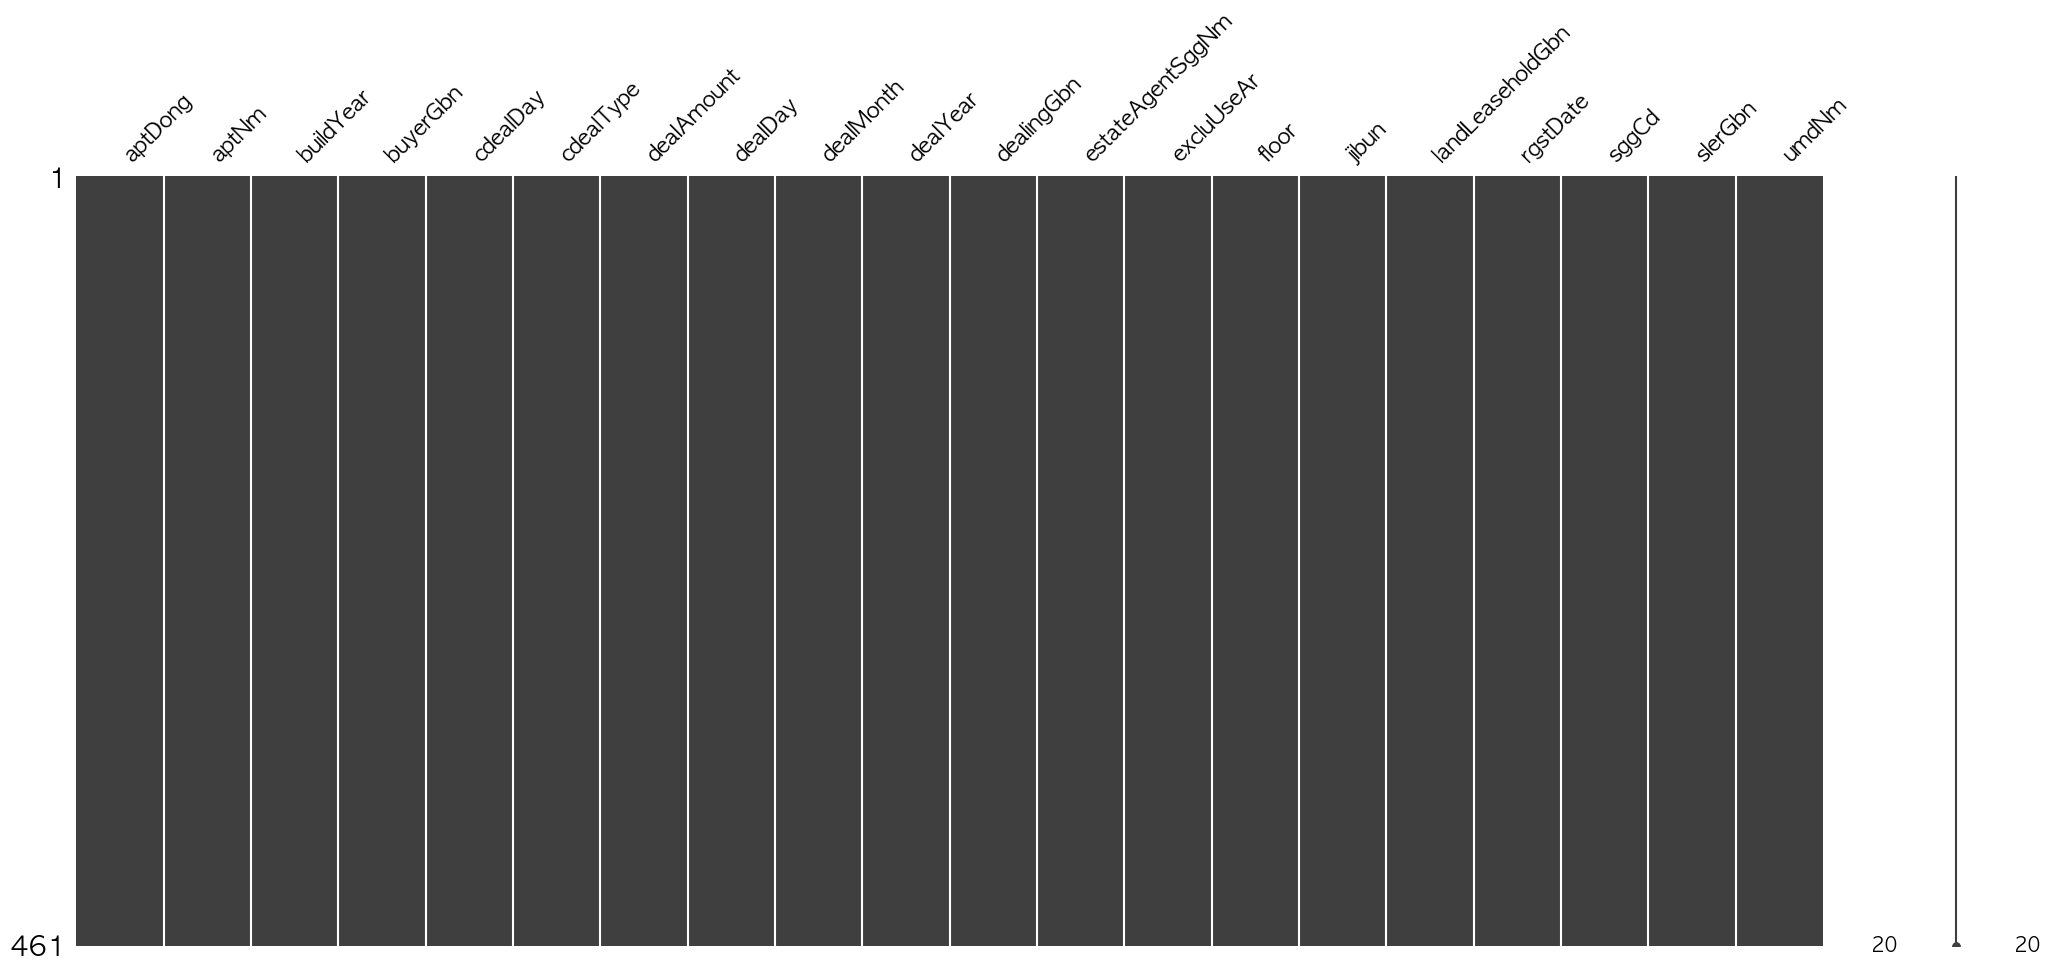

In [35]:
import missingno as msno
msno.matrix(df)

In [36]:
df.columns

Index(['aptDong', 'aptNm', 'buildYear', 'buyerGbn', 'cdealDay', 'cdealType',
       'dealAmount', 'dealDay', 'dealMonth', 'dealYear', 'dealingGbn',
       'estateAgentSggNm', 'excluUseAr', 'floor', 'jibun', 'landLeaseholdGbn',
       'rgstDate', 'sggCd', 'slerGbn', 'umdNm'],
      dtype='object')

In [37]:
#전처리
year = 2025 #현재 년도

df = df.copy()
# 금액 문자열 → 숫자형
df['dealAmount'] = df['dealAmount'].astype(str).str.replace(',', '').astype(int)

# 노후도 계산
df['buildingAge'] = (year - df['buildYear'].astype(int))

#고층 여부
df['floor'] = pd.to_numeric(df['floor'], errors='coerce')
df['isHighFloor'] = df['floor'] >= 15
df['isHighFloor'] = df['isHighFloor'].astype(int)

# 계절성을 확인 하기 위해 분기별 거래 가격 변동성
df['dealYearMonth'] = df['dealYear'].astype(str) + '-' + df['dealMonth'].astype(str).str.zfill(2)
df['dealQuarter'] = pd.to_datetime(df['dealYearMonth']).dt.quarter

# 현재 지역은 결측치가 없지만 혹시 모를 상황을 대비해 결측치 제거 코드
# 카테고리형 지역
df['umdNm'] = df['umdNm'].fillna('미상')

# 결측치 제거
df.dropna(subset=['excluUseAr', 'floor', 'dealAmount', 'buildYear'], inplace=True)

# 입력 변수 (X), 타겟 변수 (y)
X = df[['excluUseAr', 'floor', 'isHighFloor', 'buildingAge', 'dealMonth', 'dealQuarter', 'umdNm']]
y = df['dealAmount']

In [38]:
df.dtypes

aptDong             object
aptNm               object
buildYear           object
buyerGbn            object
cdealDay            object
cdealType           object
dealAmount           int64
dealDay             object
dealMonth           object
dealYear            object
dealingGbn          object
estateAgentSggNm    object
excluUseAr          object
floor                int64
jibun               object
landLeaseholdGbn    object
rgstDate            object
sggCd               object
slerGbn             object
umdNm               object
buildingAge          int64
isHighFloor          int64
dealYearMonth       object
dealQuarter          int32
dtype: object

In [39]:
#인코딩 및 데이터 학습 분리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# 범주형 컬럼 인코딩
cat_cols = X.select_dtypes(include='object').columns.tolist()
ct = ColumnTransformer([('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)], remainder='passthrough')

X_encoded = ct.fit_transform(X)

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


In [40]:
#회귀모델 예측
# randomforest사용 이유 : 집 값의 경우 비선형성을 띄는 데이터가 많기 때문에 이런 구조에서 가장 유리하다고 판단 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)

print('MAE:', mean_absolute_error(y_test, preds))
print('R² Score:', r2_score(y_test, preds))


MAE: 9198.010708467162
R² Score: 0.7705124749271782


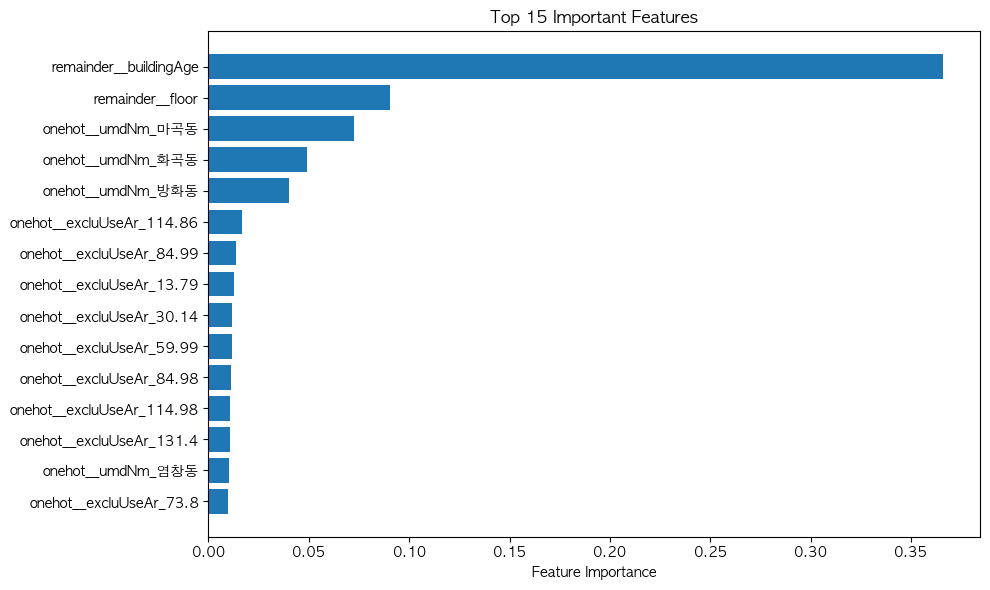

In [41]:
#변수 중요도 시각화
import matplotlib.pyplot as plt
import numpy as np

feature_names = ct.get_feature_names_out()
importances = model.feature_importances_
indices = np.argsort(importances)[-15:]  # 상위 15개

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), feature_names[indices])
plt.xlabel('Feature Importance')
plt.title('Top 15 Important Features')
plt.tight_layout()
plt.show()


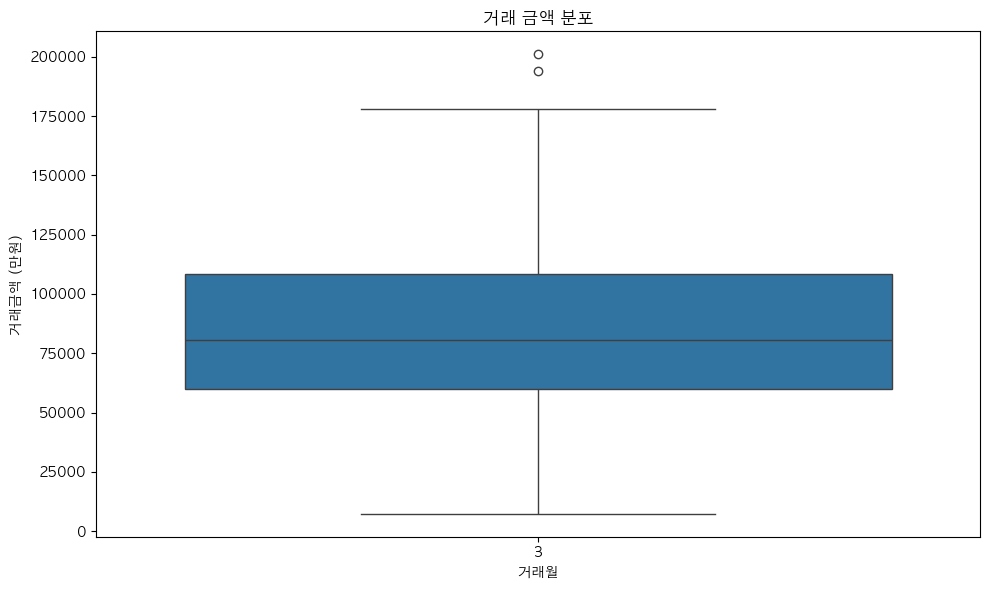

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.histplot(df['dealAmount'], bins=50, kde=True)
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='dealMonth', y='dealAmount')
plt.title('거래 금액 분포')
plt.ylabel('거래금액 (만원)')
plt.xlabel('거래월')
# plt.xticks(rotation=45)  # 글씨 겹침 방지
plt.tight_layout()   
plt.show()


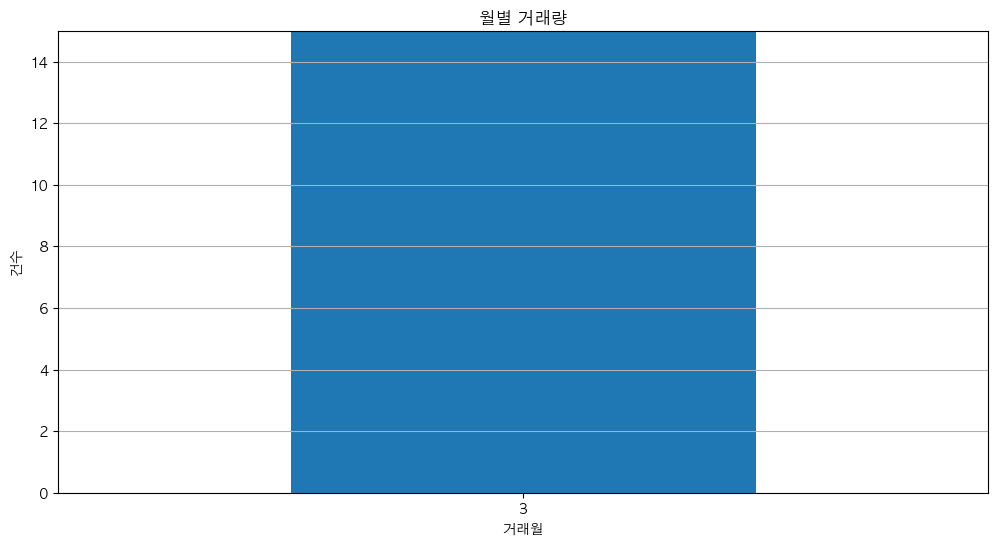

In [43]:
month_group = df.groupby('dealMonth')['dealAmount'].count()
month_group.plot(kind='bar', figsize=(12, 6))
plt.xticks(rotation=0)
plt.title('월별 거래량')
plt.xlabel('거래월')
plt.ylabel('건수')
plt.ylim(0, 15)
plt.grid(axis='y')
plt.show()

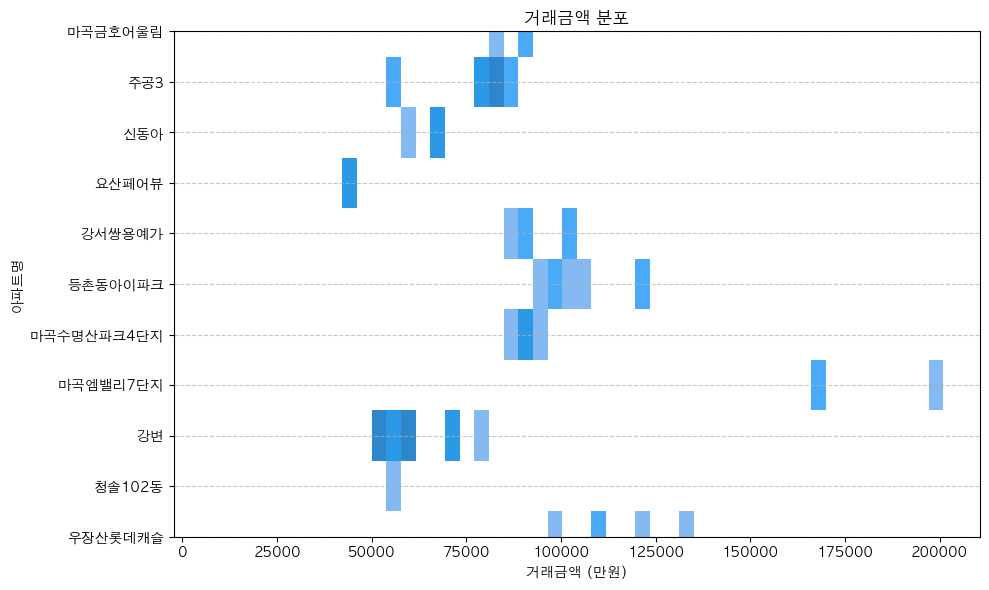

In [44]:
plt.figure(figsize=(10,6))
sns.histplot(df, x = 'dealAmount' , y = 'aptNm', bins=50)
plt.title('거래금액 분포')
plt.xlabel('거래금액 (만원)')
plt.ylabel('아파트명')

# y축을 정수 단위로 설정
from matplotlib.ticker import MaxNLocator
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 10)  # y축 최대 50건까지만 표시

plt.tight_layout()
plt.show()


In [45]:
df.dtypes

aptDong             object
aptNm               object
buildYear           object
buyerGbn            object
cdealDay            object
cdealType           object
dealAmount           int64
dealDay             object
dealMonth           object
dealYear            object
dealingGbn          object
estateAgentSggNm    object
excluUseAr          object
floor                int64
jibun               object
landLeaseholdGbn    object
rgstDate            object
sggCd               object
slerGbn             object
umdNm               object
buildingAge          int64
isHighFloor          int64
dealYearMonth       object
dealQuarter          int32
dtype: object

In [46]:
# 쉼표, 공백, 이상값 제거 후 수치형 변환
df['excluUseAr'] = pd.to_numeric(df['excluUseAr'].astype(str).str.replace(',', '').str.strip(), errors='coerce')
df['floor'] = pd.to_numeric(df['floor'], errors='coerce')
df['buildYear'] = pd.to_numeric(df['buildYear'], errors='coerce')
df['dealMonth'] = pd.to_numeric(df['dealMonth'], errors='coerce')
df['dealYear'] = pd.to_numeric(df['dealYear'], errors='coerce')

In [47]:
print(df[['excluUseAr', 'floor', 'buildYear']].isnull().sum())

excluUseAr    0
floor         0
buildYear     0
dtype: int64


In [48]:
# 수치형 컬럼 추출
num_df = df.select_dtypes(include=['int64', 'float64'])

#필요 없는 컬럼 제거
num_df = num_df.drop(columns = ['dealMonth', 'dealYear'])

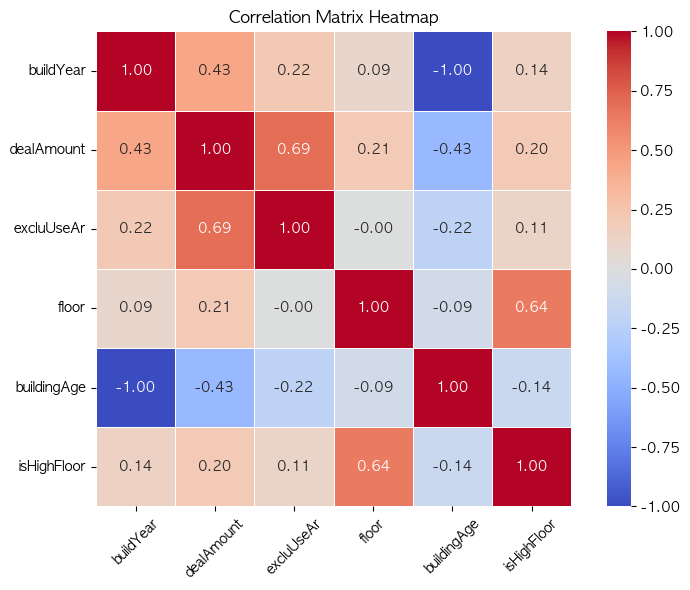

In [49]:
# 상관계수 행렬 전체 계산
corr_matrix = num_df.corr()

# heatmap 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=0.5)

plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

중간 분석 \
상관계수 분석과 모델 기반 변수 중요도를 병행해보니, \
단순히 상관관계가 높은 변수(excluUseAr)가 모델에서 가장 중요한 건 아니었다.\
오히려 buildingAge처럼 분기 기준에서 역할을 하는 변수가 실제 예측에는 더 중요한 역할을 한다.

데이터가 바뀌었더니 위의 분석이 기각됨

In [50]:
# 모델 정의
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1,
                                      max_depth=10, num_leaves=50,
                                      min_data_in_leaf=5, verbose=-1,
                                      random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42)
}

results = []

# 모델 훈련 및 평가
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append({
        'Model': name,
        'MAE': mae,
        'R2': r2
    })

# 결과 정리
results_df = pd.DataFrame(results)
results_df.sort_values(by='MAE', inplace=True)
results_df
# print(results_df)

,Model,MAE,R2
0,LinearRegression,9029.179551,0.679221
1,RandomForest,9198.010708,0.770512
3,XGBoost,10556.093750,0.647711
2,LightGBM,14010.852410,0.440062


LinearRegression의 MAE값이 가장 낮아 예측값이 나머지 모델보다 오차가 덜하다.\
하지만 RandomForest의 R2값이 나머지 가장 성능이 좋다.\
예측값의 오차를 줄이는게 더 중요할 경우 LinearRegression을 사용해야하고, \
전체적인 데이터 설명력과 일반화가 중요하다면 Randomforest를 사용해야한다. \
이전에는 실거래 데이터에서 하나의 페이지에서 10개의 데이터밖에 가지고 오지 않아 정확도가 떨어졌으며 \
데이터를 더 많이 담아 약 450개정도의 데이터를 사용하였고 MAE와 R2스코어가 개선이 됨 \
현재 스코어는 쓸만하지만 실제로 사용되기엔 조금 정확도가 떨어지는 수준이며 \
추가적인 피처엔지니어링으로 학군, 교통접근성등의 데이터가 필요할것으로 판단


In [51]:
from base_model_utils import preprocess_base_df
df = preprocess_base_df(df)
df.to_csv('01_base_model_df.csv', index=False)